# Benchmark optimizers 

In [2]:
import sys, os
sys.path.append(os.path.dirname(os.getcwd()))

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from copy import copy
plt.rcParams.update({'font.size': 18})

In [4]:
def plot_results(inputs,obj):
    f = plt.figure(figsize=(20,3))
    ax = f.add_subplot(121)
    ax2 = f.add_subplot(122)
    ax.set_ylabel('X')
    ax.set_xlabel('function evaluation')
    ax.plot(inputs)
    ax2.set_ylabel('Normalized $\epsilon$')
    ax2.set_xlabel('function evaluation'); ax2.set_yscale('log')
    ax2.plot(obj,'--b');  

In [5]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import pickle
import numpy as np
from modules.bayes_optimization import BayesOpt, negUCB, negExpImprove
from modules.OnlineGP import OGP
import numpy as np
import importlib
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output
import sys
import os
sys.path.insert(1, '/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/GPTrelated')
saveResultsQ = False
import scipy
import tensorflow as tf
# from CorrectDefocus import CorrectDefocus

In [6]:
gpus = tf.config.experimental.list_physical_devices('GPU')
os.environ["CUDA_VISIBLE_DEVICES"]="0" # specify which GPU to use
if gpus:
  try:
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
  except RuntimeError as e:
    print(e)

# Booth function

In [28]:
ndim = 6 #input dimension, set to 2 for two hexapoles
acquisition_delay = 0  #how long to wait between acquisitions- relevant for expriment, not for simulation

dev_ids =  [str(x+1) for x in np.arange(ndim)] #creat device ids (just numbers)
# Parameters in the order of H1, dH, S6, S7, Obj, S3, S4

x_low = np.asarray([1000, -40, 387000, -685000, 119000, 640000])
x_high = np.asarray([2800, 40, 393000, -622500, 120300, 651000])

# start_point = [[0.28027778, 0.23793442, 0.71989302, 0.32284652, 0.34620708, 0.90389698]]
rs = np.random.RandomState()
start_point = [[rs.rand() for i in range(6)]]
print(start_point[0] * (x_high - x_low) + x_low)

S2 = 1.0

print(start_point)
model_path = 'CNNmodels/VGG16_emit+defocus_test6_attempt3.h5'
mi_module = importlib.import_module('machine_interfaces.machine_interface_GPT')
mi = mi_module.machine_interface(dev_ids = dev_ids, start_point = start_point, 
                                 CNNoption=1, CNNpath = model_path, DefocusOption = 0, S2 = S2) 
mi.aperture = 0

[ 1.72585165e+03 -3.98045370e+01  3.89085932e+05 -6.51244870e+05
  1.19379651e+05  6.40133140e+05]
[[0.40325091397576274, 0.002443287844226094, 0.34765536905148475, 0.540082082384156, 0.2920395503906673, 0.012103612134202746]]
Model loaded


[[0.40325091 0.00244329 0.34765537 0.54008208 0.29203955 0.01210361]]
1.0
Using CNN prediction.
saving ronchigram...
[0.23138493]


Text(0.5, 0, '$\\alpha_x \\ \\mathrm{(mrad)}$')

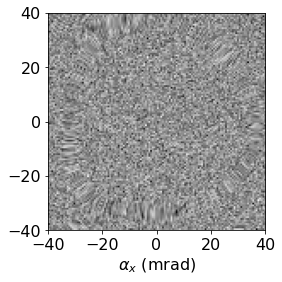

In [29]:
print(mi.x)
print(mi.S2)
#check the reading objective and reading defocus are working
temp = mi.getState()
print(temp[1][0])
temp = np.load('ronchigram.npy')
plt.imshow(temp, extent = [-40, 40, -40, 40], cmap='gray')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel(r"$\alpha_x \ \mathrm{(mrad)}$", fontsize = 16)
# plt.ylabel(r"$\alpha_y \ \mathrm{(mrad)}$", fontsize = 16)

# SLAC GP

In [18]:
from modules.bayes_optimization import BayesOpt, negUCB, negExpImprove
from modules.OnlineGP import OGP
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
import importlib

In [30]:
# TFGP parameters for CNN trained with defocus + emittance
gp_ls = np.array(np.ones(ndim)) * [0.542,  0.706, 0.394, 0.244, 0.185, 0.154]
gp_amp = 0.162
gp_noise_variance = 0.0002

gp_precisionmat = (np.diag(1/gp_ls**2))
hyperparams = {'precisionMatrix': gp_precisionmat, 'amplitude_covar': gp_amp, 'noise_variance': gp_noise_variance} 
gp = OGP(ndim, hyperparams)

In [31]:
#create the bayesian optimizer that will use the gp as the model to optimize the machine 
optimize_kernel_on_the_fly = None
opt = BayesOpt(gp, mi, acq_func="UCB", start_dev_vals = mi.x, dev_ids = dev_ids,
              optimize_kernel_on_the_fly = optimize_kernel_on_the_fly)
opt.ucb_params = np.array([2, None])
opt.defocus_correction = False
opt.bounds = [(0,1),(0,1),(0,1),(0,1),(0,1),(0,1)]
opt.iter_bound = True
y_gp=[]

Supposed to be grabbing initial machine state...
Using CNN prediction.
saving ronchigram...
x_init [[0.40325091 0.00244329 0.34765537 0.54008208 0.29203955 0.01210361]]
y_init [[0.23138493]]


iteration = 49
Using CNN prediction.
saving ronchigram...
current position: [[0.16022212 1.11151225 1.07262866 0.43481627 1.06898492 0.25330561]] current objective value: [[-0.87481646]]
Using CNN prediction.
saving ronchigram...


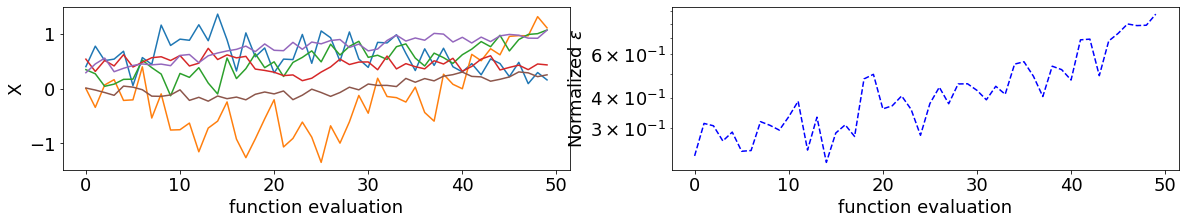

multi-processing, minimize
Using CNN prediction.
saving ronchigram...


In [32]:
Niter = 50
for i in range(Niter):
    clear_output(wait=True) 
    print ('iteration =', i)
    print ('current position:', mi.x, 'current objective value:', -mi.getState()[1])
    y_gp.append(mi.getState()[1][0])
    plot_results(opt.X_obs,y_gp); 
    plt.show()
    opt.OptIter()


min f: 0.87482


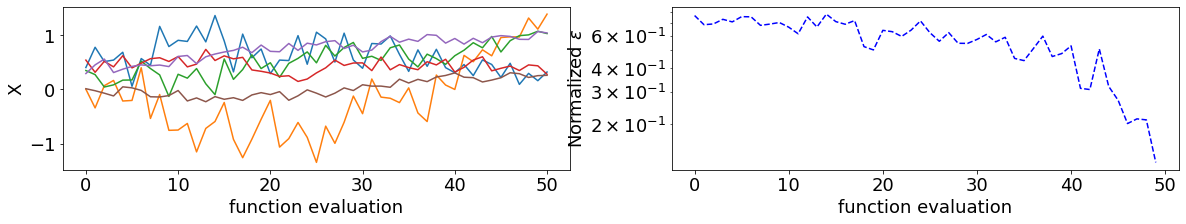

In [33]:
x_gp = opt.X_obs
print("min f: {:.5f}".format(np.amax(y_gp)) )
plot_results(x_gp,1-np.asarray(y_gp)); 
plt.show()

In [37]:
np.save('SLAC_GP_X-obs_nbest3_nstart1_emit+defocus_0.423-0.101-fullGPT.npy',opt.X_obs)
np.save('SLAC_GP_Y-obs_nbest3_nstart1_emit+defocus_0.423-0.101-fullGPT.npy',y_gp)

In [9]:
x_gp = np.load(path + 'SLAC_GP_X-obs_nbest3_nstart1_emit+defocus_0.423-0.101-fullGPT.npy')
y_gp = np.load(path + 'SLAC_GP_Y-obs_nbest3_nstart1_emit+defocus_0.423-0.101-fullGPT.npy')

In [48]:
ind = np.unravel_index(np.argmin(Z, axis=None), Z.shape)
print(ind)

(9, 8)


In [49]:
print(x_gp[np.argmax(y_gp),0], x_gp[np.argmax(y_gp), 1])
print(np.amax(y_gp))

0.36567956155397874 0.4570565113450329
0.9676619172096252


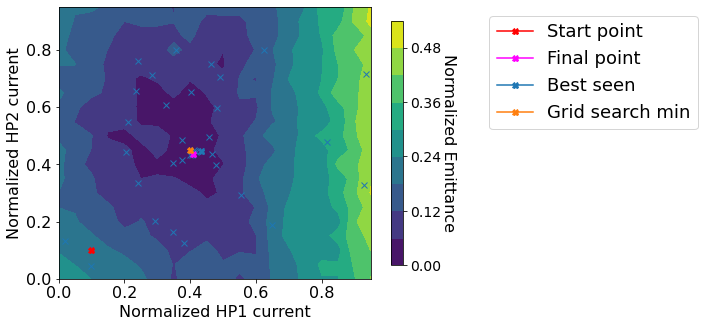

In [63]:
# make contour plot
fig, ax = plt.subplots(1,1, figsize=(7,5))
img = ax.contourf(X, Y, Z);
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax.set_xlabel('Normalized HP1 current', fontsize = 16)
ax.set_ylabel('Normalized HP2 current', fontsize=16)
cbar = fig.colorbar(img, ax=ax, shrink=0.9)
cbar.ax.locator_params(nbins=5)
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.tick_params(labelsize=14)
cbar.ax.set_ylabel('Normalized Emittance',fontsize = 16, rotation=270)

# Overlap searching track on top of the contour grid
# plt.plot(x_gp[:,0],x_gp[:,1],'.-y'); 
plt.plot(x_gp[:,0],x_gp[:,1],'x'); 
plt.plot(x_gp[0,0],x_gp[0,1],marker='X',color='red', label = 'Start point')
plt.plot(x_gp[-1,0],x_gp[-1,1],marker='X',color='magenta', label = 'Final point'); # Final GP point
plt.plot(x_gp[np.argmax(y_gp),0], x_gp[np.argmax(y_gp), 1], marker = 'X', color = 'C0', label = 'Best seen')
plt.plot(x[ind[1]], y[ind[0]], marker = 'X', color = 'C1', label = 'Grid search min') # Final point detected by GPy
plt.xlim([0,0.95]); plt.ylim([0,0.95]);
plt.legend(bbox_to_anchor=(1.35, 1), loc='upper left')

# Gpy

In [34]:
import GPyOpt
from numpy.random import seed 

def booth(x):
    mi.setX(x)
    y = mi.getState()[1][0]
    return 1-y

bounds =[{'name': 'x_1', 'type': 'continuous', 'domain': (0,1)}, 
         {'name': 'x_2', 'type': 'continuous', 'domain': (0,1)},
         {'name': 'x_3', 'type': 'continuous', 'domain': (0,1)},
         {'name': 'x_4', 'type': 'continuous', 'domain': (0,1)},
         {'name': 'x_5', 'type': 'continuous', 'domain': (0,1)},
         {'name': 'x_6', 'type': 'continuous', 'domain': (0,1)}]

seed(123) 

y_gpy = GPyOpt.methods.BayesianOptimization(booth,                   
                    domain=bounds,                
                    acquisition_type='EI',        
                    exact_feval = True,           
                    initial_design_type ="latin", 
                    initial_design_numdata=20,
                    X = np.array([0.40325091, 0.00244329, 0.34765537, 0.54008208, 0.29203955, 0.01210361], ndmin = 2),
                    Y = np.array([0.23138493], ndmin = 2))   
max_iter = 50
y_gpy.run_optimization(max_iter) 

Using CNN prediction.
saving ronchigram...
Using CNN prediction.
saving ronchigram...
Using CNN prediction.
saving ronchigram...
Using CNN prediction.
saving ronchigram...
Using CNN prediction.
saving ronchigram...
Using CNN prediction.
saving ronchigram...
Using CNN prediction.
saving ronchigram...
Using CNN prediction.
saving ronchigram...
Using CNN prediction.
saving ronchigram...
Using CNN prediction.
saving ronchigram...
Using CNN prediction.
saving ronchigram...
Using CNN prediction.
saving ronchigram...
Using CNN prediction.
saving ronchigram...
Using CNN prediction.
saving ronchigram...
Using CNN prediction.
saving ronchigram...
Using CNN prediction.
saving ronchigram...
Using CNN prediction.
saving ronchigram...
Using CNN prediction.
saving ronchigram...
Using CNN prediction.
saving ronchigram...
Using CNN prediction.
saving ronchigram...
Using CNN prediction.
saving ronchigram...
Using CNN prediction.
saving ronchigram...
Using CNN prediction.
saving ronchigram...
Using CNN p

min f: 0.17491
argmin f: 0.17477, 0.31763


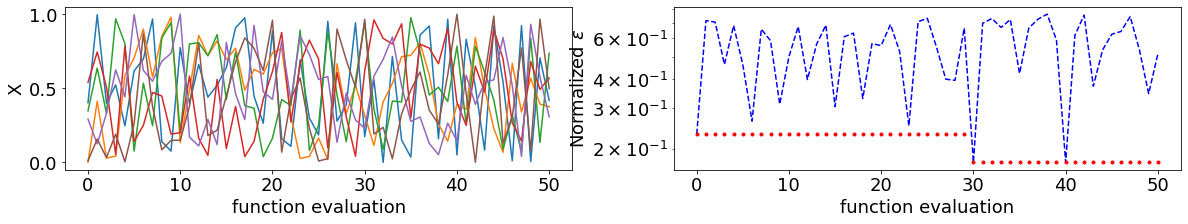

In [35]:
plot_results(y_gpy.get_evaluations()[0],y_gpy.get_evaluations()[1]);
plt.plot(y_gpy.Y_best,'.r');

print("min f: {:.5f}".format(y_gpy.fx_opt)) 
print("argmin f: {:.5f}, {:.5f}".format(y_gpy.x_opt[0], 
                                        y_gpy.x_opt[1]))

In [36]:
np.save('GPy_X-obs-fullGPT.npy', y_gpy.get_evaluations()[0])
np.save('GPy_Y-obs-fullGPT.npy', y_gpy.get_evaluations()[1])

Text(0.5, 0, '$\\alpha_x \\ \\mathrm{(mrad)}$')

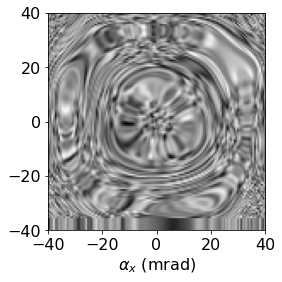

In [12]:
temp = np.load('ronchigram.npy')
plt.imshow(temp, extent = [-40, 40, -40, 40], cmap='gray')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel(r"$\alpha_x \ \mathrm{(mrad)}$", fontsize = 16)

# Simplex / L-BFGS-B 

In [41]:
class function:
    def __init__(self):
        self.my_counter= 0
        self.my_x = []
        self.my_y = []
    
    def Booth(self,x):
        print(x)
        mi.setX([x])
        y = mi.getState()[1][0]
        self.my_counter += 1
        self.my_x += [x]  
        self.my_y += [y]
        return 1-y

x0 = np.array([0.5, 0.5]).astype('float64') #this is the maximum location
xs = np.array([0.40325091, 0.00244329, 0.34765537, 0.54008208, 0.29203955, 0.01210361]) #start point

f = function()

In [42]:
from scipy.optimize import minimize

def more_optimizers(method=['Nelder-Mead','L-BFGS-B','CG'][0]):
    f = function()
    result = minimize(f.Booth, x0=xs, method=method)
    print("Found minimum at {0}".format(result.x))
    print("Number of function evaluations {0}".format(f.my_counter))
    return f.my_y , f.my_x

[0.40325091 0.00244329 0.34765537 0.54008208 0.29203955 0.01210361]
Using CNN prediction.
saving ronchigram...
[0.42341346 0.00244329 0.34765537 0.54008208 0.29203955 0.01210361]
Using CNN prediction.
saving ronchigram...
[0.40325091 0.00256545 0.34765537 0.54008208 0.29203955 0.01210361]
Using CNN prediction.
saving ronchigram...
[0.40325091 0.00244329 0.36503814 0.54008208 0.29203955 0.01210361]
Using CNN prediction.
saving ronchigram...
[0.40325091 0.00244329 0.34765537 0.56708618 0.29203955 0.01210361]
Using CNN prediction.
saving ronchigram...
[0.40325091 0.00244329 0.34765537 0.54008208 0.30664153 0.01210361]
Using CNN prediction.
saving ronchigram...
[0.40325091 0.00244329 0.34765537 0.54008208 0.29203955 0.01270879]
Using CNN prediction.
saving ronchigram...
[0.40997176 0.00248401 0.3302726  0.54908345 0.29690688 0.01230534]
Using CNN prediction.
saving ronchigram...
[0.41221204 0.00249759 0.34186111 0.5520839  0.27906001 0.01237258]
Using CNN prediction.
saving ronchigram...
[

Using CNN prediction.
saving ronchigram...
[0.41695338 0.00249529 0.33888718 0.56349019 0.26967265 0.01236297]
Using CNN prediction.
saving ronchigram...
[0.41714896 0.0024873  0.33887475 0.56479938 0.27059415 0.01232607]
Using CNN prediction.
saving ronchigram...
[0.41696718 0.00249165 0.33898181 0.56399946 0.27011061 0.01233927]
Using CNN prediction.
saving ronchigram...
[0.41675074 0.00249358 0.33958296 0.56370179 0.26959289 0.01233655]
Using CNN prediction.
saving ronchigram...
[0.41683822 0.00249428 0.33882577 0.56333361 0.26958477 0.01236944]
Using CNN prediction.
saving ronchigram...
[0.41677806 0.00249767 0.3388437  0.56348063 0.26939751 0.01236331]
Using CNN prediction.
saving ronchigram...
[0.41674305 0.00249075 0.33922057 0.56424387 0.27001996 0.01232983]
Using CNN prediction.
saving ronchigram...
[0.41641217 0.0024999  0.33934827 0.56274951 0.26890707 0.01236799]
Using CNN prediction.
saving ronchigram...
[0.41696476 0.00249045 0.33899313 0.56428691 0.27017238 0.01233655]
U

Using CNN prediction.
saving ronchigram...
[0.41687825 0.00249213 0.33895896 0.56404949 0.26998708 0.01234377]
Using CNN prediction.
saving ronchigram...
Found minimum at [0.41688175 0.00249213 0.33898718 0.56400796 0.26996877 0.01234411]
Number of function evaluations 150


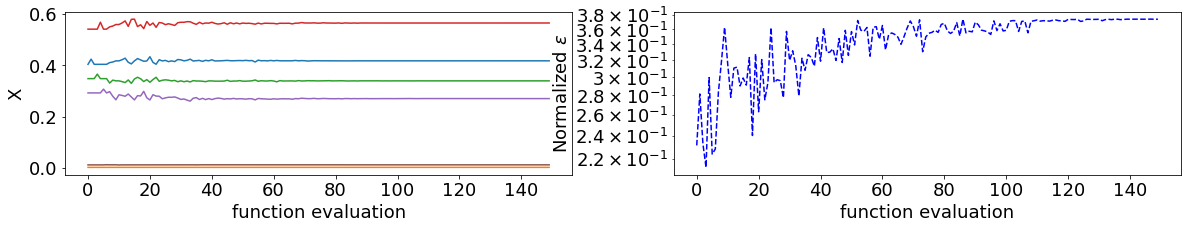

In [43]:
y_simplex , x_simplex = more_optimizers(method='Nelder-Mead')
plot_results(x_simplex,y_simplex)

In [46]:
np.save('Simplex_X-obs-fullGPT.npy',x_simplex)
np.save('Simplex_Y-obs-fullGPT.npy', y_simplex)
print(np.amin(y_simplex))

0.21284866333007812


In [68]:
# y_LBFGSB ,x_LBFGSB =more_optimizers(method='L-BFGS-B')
# plot_results(x_LBFGSB,y_LBFGSB)

# Compare different minimization tools

In [7]:
# Load the data from previous calculations, Xs are not necessary.
path = 'Results/BenchmarkTests/VGG16_emit+defocus_test6_attempt3_HPonly/'
path = ''
x_gpy = np.load(path + 'GPy_X-obs-fullGPT.npy')
y_gpy = np.load(path +'GPy_Y-obs-fullGPT.npy')
x_simplex = np.load(path +'Simplex_X-obs-fullGPT.npy')
y_simplex = np.load(path +'Simplex_Y-obs-fullGPT.npy')

/home/chenyu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  # Remove the CWD from sys.path while we load stuff.


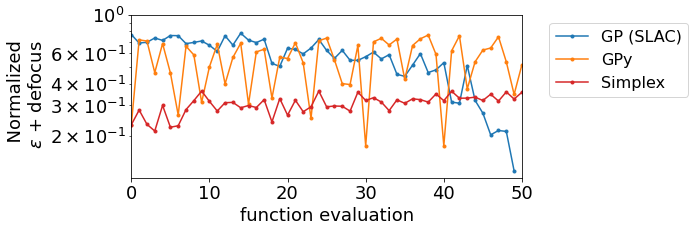

In [51]:
fig, ax = plt.subplots(1,1, figsize=(7,3)) 
plt.xlabel('function evaluation'); 
plt.ylabel('  Normalized\n $\epsilon$ + defocus')
plt.plot(1-np.asarray(y_gp),marker='.',linestyle='-',label='GP (SLAC)');
plt.plot(y_gpy,marker='.',linestyle='-',label='GPy');
plt.plot(y_simplex,marker='.',linestyle='-',color = 'C3',label='Simplex');
plt.legend(fontsize = 16, loc = 'upper left', bbox_to_anchor=(1.05, 1)); 
plt.xlim([0,50]);
plt.yscale('log');
plt.ylim([0, 1]);

# plt.title('Benchmark Test');

In [40]:
ax.t

AttributeError: 'AxesSubplot' object has no attribute 'x'

## Compare different SLAC GP parameters

In [6]:
y_gp_1 = np.load(path + 'SLAC_GP_Y-obs_nbest3_nstart1_emit+defocus.npy')
y_gp_2 = np.load(path + 'SLAC_GP_Y-obs_nbest3_nstart1_emit+defocus_60iter_10xSmallerLS.npy')
y_gp_3 = np.load(path + 'SLAC_GP_Y-obs_nbest3_nstart1_emit+defocus_refine_10xSmallerLS.npy')
y_gp_4 = np.load(path + 'SLAC_GP_Y-obs_nbest3_nstart1_emit+defocus_30iter_noReset_10xSmallerLS.npy')

/home/chenyu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  if __name__ == '__main__':


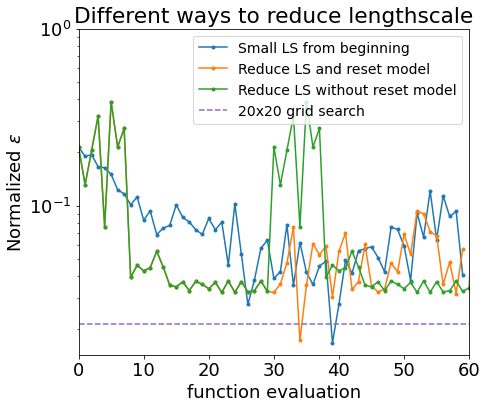

In [83]:
f = plt.figure(figsize=(7,6));  plt.xlabel('function evaluation'); plt.ylabel('Normalized $\epsilon$')
plt.plot(1 - y_gp_2,marker='.',linestyle='-',label='Small LS from beginning');
plt.plot(1-np.concatenate((y_gp_1, y_gp_3)),marker='.',linestyle='-',label='Reduce LS and reset model');
plt.plot(1-np.concatenate((y_gp_1, y_gp_4)),marker='.',linestyle='-',label='Reduce LS without reset model');
plt.axhline(y = np.amin(Z), linestyle = '--', color='C4', label = '20x20 grid search')
plt.legend(fontsize = 14, loc = 'upper right'); 
plt.xlim([0,60]);
plt.yscale('log');
plt.ylim([0, 1]);
plt.title('Different ways to reduce lengthscale');

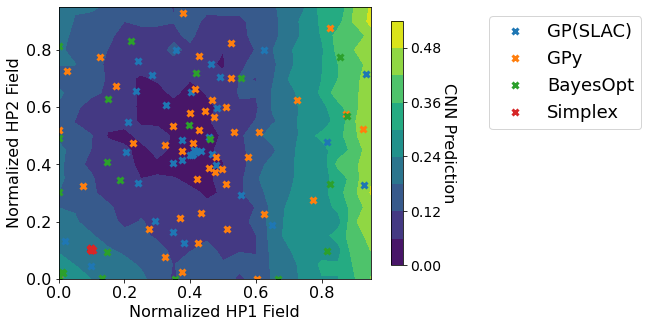

In [95]:
# make contour plot
fig, ax = plt.subplots(1,1, figsize=(7,5))
img = ax.contourf(X, Y, Z);
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax.set_xlabel('Normalized HP1 Field', fontsize = 16)
ax.set_ylabel('Normalized HP2 Field', fontsize=16)
cbar = fig.colorbar(img, ax=ax, shrink=0.9)
cbar.ax.locator_params(nbins=5)
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.tick_params(labelsize=14)
cbar.ax.set_ylabel('CNN Prediction',fontsize = 16, rotation=270)


plt.plot(x_gp[:,0],x_gp[:,1],'x', ms = 6, mew = 3, color = 'C0', label = 'GP(SLAC)'); 
plt.plot(x_gpy[:,0],x_gpy[:,1],'x', ms = 6, mew = 3,color = 'C1', label = 'GPy'); 
plt.plot(x_bo[:,0],x_bo[:,1],'x', ms = 6, mew = 3,color = 'C2', label = 'BayesOpt'); 
plt.plot(x_simplex[:,0],x_simplex[:,1],'x', ms = 6, mew = 3, color = 'C3', label = 'Simplex'); 

plt.xlim([0,0.95]); plt.ylim([0,0.95]);
plt.legend(bbox_to_anchor=(1.35, 1), loc='upper left')